###### Roger Ho
## IS590PR - Fall 2017
## Assignment 5:  Analysis with multi-file or multi-table data using Pandas
### Data Set: Federal Elections Commission

http://classic.fec.gov/finance/disclosure/ftpdet.shtml files for download and the metadata.

Refer to examples in the Notebook I used in class as needed for starting points.  It is here: https://github.com/iSchool-590PR-2017Fall/590PR-examples/blob/master/FEC_pandas.ipynb

Also refer to Chapters 5 & 8 of the McKinney book for more examples. 

Note you may have to add support for the other data files in the FEC data set. Read their metadata pages to understand their contents.

# Instructions:
* **DO NOT copy the whole lecture notebook** into this one, because a lot of it does not pertain directly to the analysis in the assignment.
* **Choose 3 of the analytical queries you are going to implement from the lists below. You must try at least 1 from the multi-file queries. Then, for your fourth query, come up with something else different from any of these to implement. Make sure your English description of its purpose is clear.**
* Add the code necessary to complete each one using Pandas DataFrames and/or Pandas Series. Clearly label each one with "Markdown" cells above them, and reasonable amounts of documentation between any intermediate results to show how you created the result. 
* Once you have things working, delete any wrong or experimental code that you may still have lingering, so that what remains shows just the complete start-to-finish process of loading the data and producing your analytical results.
* Save the notebook with your output shown.
* Commit & Push this notebook file before the due date so I can see your work in GitHub Classroom for grading & feedback.

# QUERIES TO CHOOSE FROM:

[General tips: Unless stated otherwise, you may use just a single 2-year data set to compute any of these. Any time a query description has 'per' or 'each', that means you need to use groupby on the column(s) that follow. But some queries described without those words also still need groupby]

## Single-file queries:
* List all individuals who donated a TOTAL of over 100,000 dollars. Show name, city, state, employer, occupation, and total amount. [Tip: You must groupby name+city+state or by name+zipcode]
* List top 10 cities by total individual donations. Try creating a visual barchart with matplotlib.
* Compute the total amount of donations received PER MONTH from all individuals together, listing in date order. [Tips: You'll have to correct the import parsing of TRANSACTION_DT in the itcont.txt file -- The original text files have dates like '13102017' for Oct. 13, 2017. ]
* Total Expenditures by all committees per month. [Tip: You'll have to correct the import parsing of TRANSACTION_DT in the oppexp.txt file -- The original text files have dates like '13/10/2017' for Oct. 13, 2017.]
* List name, city, and state of individual people who made more than 1,000 donation **transactions**.  It's crazy, but there's even someone here in Champaign if you're using the 2015-2016 data.
* List the top 20 professions (Occupations) for total donations.

* For donations directly to the presidential election only (2015-2016 files), determine total individual donations PER STATE.


## Multi-file queries (needing merge or join).  Some of these are good ways to see corruption in action:
* Find people who donated over 5000 directly to a Senate or House candidate who's not even in their own state, and show the details. [Tip: You'll need to compare the candidate's state to the individual donor's state after you get them joined.]
* List every INCUMBENT Senate & House candidate alphabetically, showing their Name, State, and Party affiliation. For each one, list the name of every Corporation or other PAC that has "bought" them with huge donations (for example, totaling more than 25,000 dollars each). [Incumbent means they're already in office and are running for re-election. This is viewable in the "CAND_ICI" column.]
* Join Committees with the "itpas" file and the Candidate file. Then use groupby properly to build a dataframe with CMTE_ID as the index, a column for Committee name, and columns for each political party of interest. In the party columns, it shows how much total money it spent on any candidates from each party.  With this we can see things like how strongly the National Rifle Association and "Big Oil" companies support Republicans and how strongly many labor unions support Democrats, or how organizations protecting natural resources support Democrats, Green Party, or other fringe parties, etc. [The list of parties coded in the database is shown here: http://classic.fec.gov/finance/disclosure/metadata/DataDictionaryPartyCodeDescriptions.shtml]

* Download all 3 individual donations files (itcont.txt) from 2014, 2016, and 2018. Figure out how to concatenate them (just the columns you need) into a single DataFrame covering that whole range from 2013-2018. Then use that to compute an analysis of questions such as:
    * Political activity is much higher for Presidential elections than in other years. Find out whether the level of donations to Senate and House campaigns goes up or down at that time compared to other years.
    * Find out how many and what percentage of individual donors have contributed to BOTH a Democratic and a Republican candidate at some point.
    

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib

####  First create functions for processing data into a format so that the data values and its header values could all be loaded into a pandas dataframe

In [3]:
def get_header(header_file) -> list:
    """
    Opens the passed in discription file (They would be in csv format containing only one line of column names)
    Read the line of the file, and use strip() and split(',') to get rid of unwanted spaces and returning a list of 
    column names that are seperated by the comma.
    
    :param header_file: CSV files with one line of data that would be served as the column names (header row)
    :return columns: A list of strings containing the column names
    """
    with open(header_file, 'r') as cols:
        columns = cols.readline().strip().split(',')
    return columns

#### Generalize the creation of pandas dataframe on the data file and its header name list for easier calling to analyze different files and data

In [4]:
def CSV_DF(data_file, header_file, usecols = [], dtype=None, sep = "|", index_col = False):
    """
    Generalize the creation of the pandas dataframe from the csv data and header files for easier calling and reusability
    """
    header_list = get_header(header_file)
    if len(usecols) == 0:
        return pd.read_csv(data_file, dtype = dtype,sep = sep, index_col = index_col, names = header_list, encoding = 'utf-8')
    else:
        return pd.read_csv(data_file, dtype = dtype,sep=sep, index_col=index_col, names=header_list,encoding='utf-8',usecols=usecols)


# Query 1:
#### Total Expenditures by all committees per month.

In [5]:
# seting data file and header file location for reading data into the pandas dataframe
operating_Expenditures = "./operating_Expenditures/oppexp.txt"
operating_Expenditures_header = "./operating_Expenditures/oppexp_header_file.csv"

In [6]:
# In order to calculate total expenditures by all committees per month, we only need the data of committee id ('CMTE_ID'),
# Transaction date (TRANSACTION_DT) and transaction amount (TRANSACTION_AMT). Thus we only use those three columns
# when reading in the data with usecols and setting their data type with dtype to align the datatype of the datafram
# data and to save time when reading in data.
opExp_df = CSV_DF(operating_Expenditures, operating_Expenditures_header, 
                  usecols=['CMTE_ID','TRANSACTION_DT', 'TRANSACTION_AMT'],
                  dtype = {"TRANSACTION_AMT":float, "TRANSACTION_DT":str})

In [7]:
# A look at our dataframe
opExp_df.head()

,CMTE_ID,TRANSACTION_DT,TRANSACTION_AMT
0,C00004606,03/13/2015,600.00
1,C00004606,03/27/2015,982.80
2,C00378067,03/31/2015,233.96
3,C00010470,03/31/2015,269.37
4,C00465211,03/01/2015,750.00


In [8]:
# Create functions to see if their are date values we'll have to correct the import parsing of TRANSACTION_DT in 
# the oppexp.txt file whether the original text files have dates like '13/10/2017' for Oct. 13, 2017.
# So we look at all the dates to see if there are any |dates that have the first two digits that represents months larger 
# than 12 or days that are larger than 31 or if any of them are smaller than 0.
# If there are, it means that incorrect expression of dates exists and we will need to change it accordingly
def find_abnormal_months(data):
    try:
        if int(data[0:2]) > 12 or int(data[0:2]) <= 0:
            print(data)
    except:
        print(data)

        
def find_abnormal_days(data):
    try:
        if int(data[3:5]) > 31 or int(data[3:5]) <= 0:
            print(data)
    except:
        print(data)

In [9]:
opExp_df.TRANSACTION_DT.apply(find_abnormal_months)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
           ... 
1753459    None
1753460    None
1753461    None
1753462    None
1753463    None
1753464    None
1753465    None
1753466    None
1753467    None
1753468    None
1753469    None
1753470    None
1753471    None
1753472    None
1753473    None
1753474    None
1753475    None
1753476    None
1753477    None
1753478    None
1753479    None
1753480    None
1753481    None
1753482    None
1753483    None
1753484    None
1753485    None
1753486    None
1753487    None
1753488    None
Name: TRANSACTION_DT, dt

In [10]:
opExp_df.TRANSACTION_DT.apply(find_abnormal_days)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
           ... 
1753459    None
1753460    None
1753461    None
1753462    None
1753463    None
1753464    None
1753465    None
1753466    None
1753467    None
1753468    None
1753469    None
1753470    None
1753471    None
1753472    None
1753473    None
1753474    None
1753475    None
1753476    None
1753477    None
1753478    None
1753479    None
1753480    None
1753481    None
1753482    None
1753483    None
1753484    None
1753485    None
1753486    None
1753487    None
1753488    None
Name: TRANSACTION_DT, dt

##### As we can see from the above outputs, all the None NaN dates are in the correct string representation, which means we can go ahead to perform calculations and manipulations based on the dates of the data

In [11]:
# create a fucntion that finds the month value in the "TRANSACTION_DT" column to create a new column 'Transaction_month'
# containing only the months for later grouping.
def find_month(dates):
    """
    Find the month value in the column name with date values passed into it.
    The date values are in a string format of "mm/dd/yyyy"
    To extract the month, the function uses string splitting of its index
    
    :param dates: Pandas Series with values of the date
    :return dates[0:2]: String slicing that represents the month value
    """
    return dates[0:2]

In [12]:
# Drop the rows of data that does not have any data regarding transaction date with drapna()
# then apply the 'find_month' function to all the row data under the TRANSACTION_DT column to return the month values
# then save those values into a new column 'Transaction_month' in the opExp_df dataframe
opExp_df["Transaction_month"] = opExp_df.TRANSACTION_DT.dropna().apply(find_month)

In [13]:
# A look at the data frame
opExp_df.head()

,CMTE_ID,TRANSACTION_DT,TRANSACTION_AMT,Transaction_month
0,C00004606,03/13/2015,600.00,03
1,C00004606,03/27/2015,982.80,03
2,C00378067,03/31/2015,233.96,03
3,C00010470,03/31/2015,269.37,03
4,C00465211,03/01/2015,750.00,03


In [14]:
# group the data with the two columns "CMTE_ID" and "Transaction_month", and save the pandas groupby object to the
# variable op_permonth_df
op_permonth_df = opExp_df.groupby(['CMTE_ID',"Transaction_month"])

In [15]:
# Then sum up all the Transaction amounts in the TRANSACTION_AMT column to 
# calculate the Total Expenditures by all committees per month.
Total_OPMonth_CMTE = op_permonth_df.TRANSACTION_AMT.sum()

In [16]:
# Outputs of Total Expenditures by all committees per month.
Total_OPMonth_CMTE

CMTE_ID    Transaction_month
C00000422  01                    3761.26
           02                    4518.86
           03                    3236.41
           04                    2989.63
           05                    3392.54
           06                    5549.27
           07                    2046.76
           08                    1920.18
           09                    2148.84
           10                    2531.75
           11                    3908.76
           12                    2807.47
C00000489  10                    6000.00
C00000638  10                     557.11
           11                     261.03
C00000729  01                     701.72
           02                     718.13
           03                     415.52
           04                     582.49
           05                    1542.51
           06                     582.10
           07                    1875.13
           08                    1126.29
           09               

#   

# Query 2:
#### List top 10 cities by total individual donations. Try creating a visual barchart with matplotlib.

In [17]:
individual = "./individuals/itcont.txt"

In [18]:
individual_hd = "./individuals/indiv_header_file.csv"

In [19]:
# To list top 10 cities by total individual donations we only need the donation amounts and city from the data
indiv_df_top10 = CSV_DF(individual,individual_hd, usecols=['TRANSACTION_AMT','CITY'],dtype = {"TRANSACTION_AMT":float})

In [20]:
# Group with "CITY" column then count how much transactions there were for each group of city then print out the 
# datafram for checking
indiv_df_top10.groupby(["CITY"]).count().head()

,TRANSACTION_AMT
CITY,
BATON ROUGE,2
CHULA VISTA,4
COLORADO SPRINGS,16
EAST CHICAGO,7
FORT BENNING,3


In [21]:
# Create a copy of the groupby object with the number of counts of Transaction for each city
# Then sort the number of counts for each city under the TRANSACTION_AMT in decending order
copy = indiv_df_top10.groupby(["CITY"]).count()
copy.sort_values(["TRANSACTION_AMT"], axis=0, ascending=False, inplace=True)

In [22]:
# print out the top 10 data in the decending ordered dataframe. 
# Which is also the top 10 cities by total individual donations 
copy.head(10)

,TRANSACTION_AMT
CITY,
NEW YORK,592464
WASHINGTON,402456
LOS ANGELES,232119
CHICAGO,215756
HOUSTON,215425
SAN FRANCISCO,212346
PHILADELPHIA,193121
SEATTLE,192327
ARLINGTON,178155


##### Plotting with matplotlib

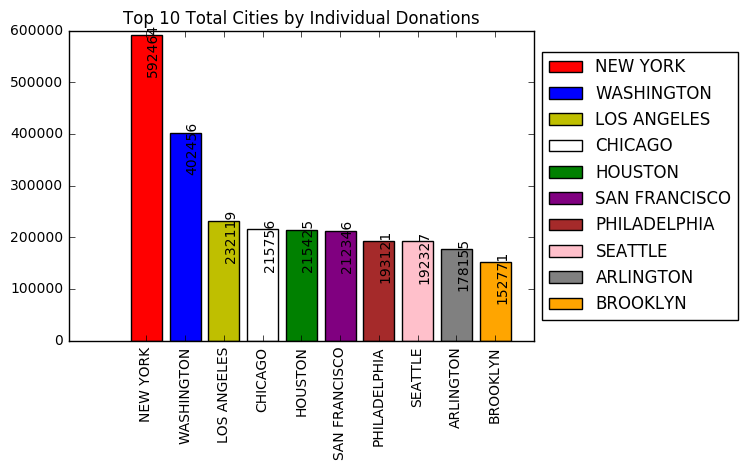

In [23]:
# Get the list of city names
city_names = list(copy.head(10).index)
# a range of numbers that corresponds to the number of cities for the x axis of the bar plot
x = range(len(city_names))
# list of transaction amount for each top 10 city for the y axis data of the bar plot
y = list(copy.head(10).TRANSACTION_AMT)

# For better visualization of different cities, create a list of 10 colors for each city
colors = ["r","b","y","white","g","purple","brown","pink","gray","orange"]

# loop through the numbers within the variable x representing the index of the x, y, and colors list to plot the 
# bar plots, assign colors and labels of city's names to each different city's bar on the plot
# as well as adding the accurate values vertically on top of each bar in the plot
for index in x:
    plt.bar(x[index], y[index], color = colors[index], label = city_names[index], align = "center")
    plt.text(x[index], y[index], str(y[index]), rotation = "vertical")


plt.title("Top 10 Total Cities by Individual Donations")
# Print out the city names as the x labels, because the names of cities are too long, show the vertically to avoid
# squishing together
plt.xticks(range(len(list(copy.head(10).index))), list(copy.head(10).index), rotation="vertical" )
# Add the legend for a better readability and put the legend on the right side of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#  
# Query 3:
#####  Find people who donated over 5000 directly to a Senate or House candidate who's not even in their own state, and show the details. 


In [24]:
# File location of the committee data file and header file.
cmte = "./Committee/cm.txt"
cmte_header = "./Committee/cm_header_file.csv"

In [25]:
# Read in the committee file, only need to use the committee state (CMTE_ST), committee id (CMTE_ID) and 
# committee type (CMTE_TP) for knowing if it is a Senate or House.
cmte_df = CSV_DF(cmte, cmte_header, usecols=['CMTE_ID', 'CMTE_ST','CMTE_TP'],
                 dtype = {"CMTE_ST":str, "CMTE_ID":str, "CMTE_TP":str})

In [26]:
# set the committee id column "CMTE_ID" as row index for the cmteid_df data frame for later joining
cmteid_df = cmte_df.set_index(["CMTE_ID"])

In [27]:
# Read in the individule donation data, this time we only need the transaction amount (TRANSACTION_AMT), 
# committee id (CMTE_ID) and the state (STATE) of the donor.
indiv_cmte_df =  CSV_DF(individual, individual_hd, usecols=['CMTE_ID', 'NAME','STATE', 'TRANSACTION_AMT'],
                            dtype = {"TRANSACTION_AMT":float, "CMTE_ID":str, "STATE":str})

In [28]:
# print out the indiv_cmte_df dataframe for checking.
indiv_cmte_df.head()

,CMTE_ID,NAME,STATE,TRANSACTION_AMT
0,C00004606,"ARNOLD, ROBERT",KS,1000.0
1,C00004606,"BICKLE, DON",KS,1000.0
2,C00004606,"ROSSMAN, RICHARD",KS,250.0
3,C00452383,"LLEWELLYN, CHARLES",MD,500.0
4,C00452383,"TYNES, TIMOTHY MR.",FL,250.0


In [29]:
# set the committee id column "CMTE_ID" as row index for the indiv_cmteid_df data frame for later joining.
indiv_cmteid_df = indiv_cmte_df.set_index(['CMTE_ID'])

In [30]:
# perform outer join on the indiv_cmteid_df dataframe with the cmteid_df dataframe, and getting rid of all NaN values
indiv_cmteid_join_pd = indiv_cmteid_df.join(cmteid_df, how = 'outer', sort=False).dropna()

In [31]:
# Perform boolean subsetting of the joined dataframe to find the values where the state of the donor does not equal to 
# committee's state and the transaction amounts are larger than 5000 where the type of the committee the donor donated
# to is either Senate (S) or House (H) then save this new finding dataframe to the 'fits' variable.
fits = indiv_cmteid_join_pd[(indiv_cmteid_join_pd["STATE"] != indiv_cmteid_join_pd["CMTE_ST"]) & 
                            (indiv_cmteid_join_pd["TRANSACTION_AMT"] > 5000) & 
                            ((indiv_cmteid_join_pd["CMTE_TP"] == "H") | 
                            (indiv_cmteid_join_pd["CMTE_TP"] == "S"))]
# Print out partial data of the fits datframe to check the outcomes
fits.head()

,NAME,STATE,TRANSACTION_AMT,CMTE_ST,CMTE_TP
CMTE_ID,,,,,
C00196774,"SCHUSTER, ELAINE",FL,5400.0,MA,S
C00196774,"SUSSMAN, S. DONALD",FL,5400.0,MA,S
C00196774,"PORTNOY, DIANE",NH,5400.0,MA,S
C00196774,"WALDRON, GERARD J",VA,5400.0,MA,S
C00196774,"JANKOWSKY, CAROL",VA,5400.0,MA,S


In [32]:
# Because there may be someone did this type of donations more than once, thus we find the unique names of the donors
# (the "NAME" column in the fits dataframe) to represent the names of the donors who donated over 5000 directly 
# to a Senate or House candidate who's not even in their own state.
fits["NAME"].unique()

array(['SCHUSTER, ELAINE', 'SUSSMAN, S. DONALD', 'PORTNOY, DIANE', ...,
       'BUCKLEY, WALTER W JR', 'KINGDON, ANLA CHENG', 'KINGDON, MARK'], dtype=object)

In [33]:
len(fits.index)

4219

In [34]:
# The total unique names of those who donated over 5000 directly to a Senate or House candidate 
# who's not even in their own state.
len(fits["NAME"].unique())

3130

In [35]:
# The statistical discription frame of the transaction amount of those who donated over 5000 directly to a Senate or
# House candidate who's not even in their own state.
fits.describe()

,TRANSACTION_AMT
count,4219.000000
mean,6417.859919
std,3974.317935
min,5050.000000
25%,5400.000000
50%,5400.000000
75%,5400.000000
max,150000.000000


#  
# Query 4:
##### Find the total individual donations from different committee's Interest Group Category to reflect how much and what groups of individuals in the US are willing to support the committees that are associate with them.

In [36]:
# Read in the Transaction amount (TRANSACTION_AMT) and committee ID (CMTE_ID) from the individual donation's data
indivDf = CSV_DF(individual, individual_hd, usecols=['CMTE_ID', 'TRANSACTION_AMT'], 
                 dtype = {"TRANSACTION_AMT":float, "CMTE_ID":str})

In [37]:
# Set the committee ID (CMTE_ID) as row index for later joining
indivDf = indivDf.set_index(['CMTE_ID'])

In [38]:
# Read in the committee ID (CMTE_ID) and Organization Interest Group Category of the committee (ORG_TP)
cmteDf = CSV_DF(cmte, cmte_header, usecols=['CMTE_ID', 'ORG_TP'], dtype = {"CMTE_ID":str})

In [39]:
# Because there are group categories that dont exist with NaN values, thus we replace those values with the string
# value "Other" then set the committee ID (CMTE_ID) as row index for later joining
cmteDf = cmteDf.replace(np.NaN, "Other")
cmteDf = cmteDf.set_index(["CMTE_ID"])

In [40]:
# Perform outer join on the two dataframes
cmteIndivDf = cmteDf.join(indivDf, how = "outer")

In [41]:
# Group the transaction amount based on the Organization Interest Group Category of the committee (ORG_TP) in the 
# joined dataframe then sum up those donations and sort those donations with decending order.
# Then it shows the result.
cmteIndivDf.groupby(["ORG_TP"]).sum().sort_values(["TRANSACTION_AMT"], ascending = False)

,TRANSACTION_AMT
ORG_TP,
Other,5.539642e+09
C,2.862882e+08
T,1.101361e+08
M,1.041536e+08
L,4.977967e+07
W,1.091025e+07
V,6.709552e+06


### The meaning of the organization Interest Group Category
###### C = Corporation
###### L = Labor organization
###### M = Membership organization
###### T = Trade association
###### V = Cooperative
###### W = Corporation without capital stock

##### We can see that aside from other organizations which did not get documented. the most donations are still made to committees affiliated with business and the amounts are much larger than others, which implies that the rich are still the most 'Influential' in politics and elections